## 开始
建立baseline之后，我们就需要根据模型当前的表现采取不同的特征工程策略，kaggle的排行榜提供了一个很好的对照，我们可以根据排行榜上的第一名来判断当前自己的baseline还有哪些提升空间。
根据上一节模型训练的表现来看，目前我们遇到的是过拟合的问题：

In [4]:
import gc
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from feature_selection.feature_utils import *
from feature_engineering.encoding import *
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold,StratifiedKFold,GroupKFold,TimeSeriesSplit
from performance_optimizing import performance_optimizing as po
import os
import random
from feature_selection.feature_utils import get_imp
from feature_selection.encoding import *
### 注意一定要提前控制随机性问题！！
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(123)

str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]: 
    dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'
    
drop_C=['C2', 'C4', 'C6', 'C8', 'C10', 'C11', 'C14']

cat=pd.read_csv('cat,csv')
cat=cat.cat.values.tolist()
params = {'num_leaves': 491,
          'colsample_bytree': 0.75,
          'subsample': 0.75,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.45,
          'reg_lambda': 0.65,
          'random_state': 47,
          'n_jobs':-1,
          'n_estimators':10000,
         }
# LOAD TRAIN
path=r'F:\python代码\kaggle_ieee'+'\\'
X_train = pd.read_csv(path+'train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv(path+'train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv(path+'test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv(path+'test_identity.csv',index_col='TransactionID', dtype=dtypes)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)


In [5]:
X=X_train
y=y_train
del X_train,y_train
gc.collect()

0

In [6]:
X.drop(drop_C,axis=1,inplace=True)
X_test.drop(drop_C,axis=1,inplace=True)

In [8]:
def lgb_model(params=None,cv=KFold(5),X=None,y=None,early_stopping_rounds=200,cols=None,categorical_feature=None,group_feature=None):

    #folds = StratifiedKFold(n_splits=NFOLDS)
    folds =cv
    if cols==None:
        columns = list(X.columns)
    else:
        columns=cols
    if group_feature:
        columns.remove(group_feature)
        splits = folds.split(X[columns], y,groups=X[group_feature])
    else:
        splits = folds.split(X[columns], y)
    y_oof = np.zeros(X.shape[0])
    score = 0


    clfs=[]
    for fold_n, (train_index, valid_index) in enumerate(splits):
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]


        clf = lgb.LGBMClassifier(**params)
        if categorical_feature:
            clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_valid,y_valid)], \
                     eval_metric='auc', verbose=100, early_stopping_rounds=early_stopping_rounds,categorical_feature=categorical_feature)
        else:
            clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_valid,y_valid)], \
                     eval_metric='auc', verbose=100, early_stopping_rounds=early_stopping_rounds)

        y_pred_valid = clf.predict_proba(X_valid)[:,1]
        y_oof[valid_index] = y_pred_valid
        print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")

        score += roc_auc_score(y_valid, y_pred_valid) / 5

        del X_train, X_valid, y_train, y_valid
        gc.collect()
        clfs.append(clf)

    print(f"\nMean AUC = {score}")
    print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")
    return clfs

In [37]:
y=pd.read_csv('y.csv')
y=y.y

## 问题分析

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.967689	valid_1's auc: 0.883455
[200]	training's auc: 0.98287	valid_1's auc: 0.888501
[300]	training's auc: 0.989902	valid_1's auc: 0.891704
[400]	training's auc: 0.994226	valid_1's auc: 0.894974
[500]	training's auc: 0.996787	valid_1's auc: 0.897366
[600]	training's auc: 0.998147	valid_1's auc: 0.899755
[700]	training's auc: 0.998918	valid_1's auc: 0.901197
[800]	training's auc: 0.999371	valid_1's auc: 0.902284
[900]	training's auc: 0.999639	valid_1's auc: 0.902604
[1000]	training's auc: 0.9998	valid_1's auc: 0.903494
[1100]	training's auc: 0.999891	valid_1's auc: 0.904437
[1200]	training's auc: 0.999942	valid_1's auc: 0.904857
[1300]	training's auc: 0.999969	valid_1's auc: 0.905255
[1400]	training's auc: 0.999984	valid_1's auc: 0.905521
[1500]	training's auc: 0.999992	valid_1's auc: 0.905833
[1600]	training's auc: 0.999996	valid_1's auc: 0.906065
[1700]	training's auc: 0.999998	valid_1's auc: 0.906388
[1800]	training's auc: 0.999999	valid_1's auc: 0.906553
[1900]	training's auc: 0.999999	valid_1's auc: 0.906908
[2000]	training's auc: 1	valid_1's auc: 0.906983
[2100]	training's auc: 1	valid_1's auc: 0.907148
[2200]	training's auc: 1	valid_1's auc: 0.907242
[2300]	training's auc: 1	valid_1's auc: 0.907669
[2400]	training's auc: 1	valid_1's auc: 0.907789
[2500]	training's auc: 1	valid_1's auc: 0.907782
[2600]	training's auc: 1	valid_1's auc: 0.907866
[2700]	training's auc: 1	valid_1's auc: 0.908002
[2800]	training's auc: 1	valid_1's auc: 0.907953
Early stopping, best iteration is:
[2692]	training's auc: 1	valid_1's auc: 0.908015
Fold 1 | AUC: 0.9080146990057908
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.96641	valid_1's auc: 0.91201
[200]	training's auc: 0.983186	valid_1's auc: 0.92412
[300]	training's auc: 0.990839	valid_1's auc: 0.929689
[400]	training's auc: 0.995169	valid_1's auc: 0.93183
[500]	training's auc: 0.997451	valid_1's auc: 0.932058
[600]	training's auc: 0.998626	valid_1's auc: 0.932191
[700]	training's auc: 0.999254	valid_1's auc: 0.932032
Early stopping, best iteration is:
[587]	training's auc: 0.998507	valid_1's auc: 0.932267
Fold 2 | AUC: 0.9322669013021163
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.968213	valid_1's auc: 0.910656
[200]	training's auc: 0.983853	valid_1's auc: 0.922499
[300]	training's auc: 0.991345	valid_1's auc: 0.927331
[400]	training's auc: 0.995393	valid_1's auc: 0.929446
[500]	training's auc: 0.997546	valid_1's auc: 0.929334
[600]	training's auc: 0.998674	valid_1's auc: 0.928999
Early stopping, best iteration is:
[449]	training's auc: 0.996642	valid_1's auc: 0.929762
Fold 3 | AUC: 0.9297624836490158
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.967903	valid_1's auc: 0.925696
[200]	training's auc: 0.983382	valid_1's auc: 0.937814
[300]	training's auc: 0.991078	valid_1's auc: 0.943154
[400]	training's auc: 0.995312	valid_1's auc: 0.945667
[500]	training's auc: 0.997563	valid_1's auc: 0.946494
[600]	training's auc: 0.998726	valid_1's auc: 0.946699
[700]	training's auc: 0.99931	valid_1's auc: 0.946713
[800]	training's auc: 0.999636	valid_1's auc: 0.946717
Early stopping, best iteration is:
[642]	training's auc: 0.999017	valid_1's auc: 0.946783
Fold 4 | AUC: 0.9467826139635424
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.968238	valid_1's auc: 0.898174
[200]	training's auc: 0.983764	valid_1's auc: 0.912631
[300]	training's auc: 0.991285	valid_1's auc: 0.918559
[400]	training's auc: 0.99535	valid_1's auc: 0.921557
[500]	training's auc: 0.997514	valid_1's auc: 0.923483
[600]	training's auc: 0.998652	valid_1's auc: 0.924377
[700]	training's auc: 0.999262	valid_1's auc: 0.925049
[800]	training's auc: 0.999603	valid_1's auc: 0.925207
[900]	training's auc: 0.999793	valid_1's auc: 0.925266
[1000]	training's auc: 0.999894	valid_1's auc: 0.925457
[1100]	training's auc: 0.999945	valid_1's auc: 0.925463
[1200]	training's auc: 0.999972	valid_1's auc: 0.925689
[1300]	training's auc: 0.999986	valid_1's auc: 0.92565
[1400]	training's auc: 0.999993	valid_1's auc: 0.925658
[1500]	training's auc: 0.999997	valid_1's auc: 0.92564
[1600]	training's auc: 0.999998	valid_1's auc: 0.925597
[1700]	training's auc: 0.999999	valid_1's auc: 0.925487
Early stopping, best iteration is:
[1550]	training's auc: 0.999998	valid_1's auc: 0.925713
Fold 5 | AUC: 0.9257133229003753

Mean AUC = 0.9285080041641682
Out of folds AUC = 0.9198989085628231

我们之前做了相关性分析得到了V系列特征的很多冗余特征以及C系列特征的高冗余特征，这些特征的存在会一定程度上影响模型的训练:
1、稀释特征重要性 https://datascience.stackexchange.com/questions/12554/does-xgboost-handle-multicollinearity-by-itself；
2、冗余的特征占用更多的内存需要更多的训练时间；
3、重点，太多高相关的特征组成的高相关特征组如果占比太高，举个极端的例子，假设我们有1000个特征，其中有999个特征A完全相同，一个完全不相关的特征B，则每次采样可能都采样不到B，最终导致很多基树都是在A这个特征上分裂，从而大大降低了gbdt的基学习器的多样性
等等
具体后面会总结。

In [9]:
cat=pd.read_csv('cat.csv')
cat=cat.cat.values.tolist()
cols=list(X.columns)

In [10]:
clfs=lgb_model(params=params,cv=KFold(5),X=X,y=y,early_stopping_rounds=200,cols=cols,categorical_feature=cat,group_feature=None)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.970044	valid_1's auc: 0.881123
[200]	training's auc: 0.984079	valid_1's auc: 0.886636
[300]	training's auc: 0.991062	valid_1's auc: 0.891899
[400]	training's auc: 0.995247	valid_1's auc: 0.896104
[500]	training's auc: 0.997541	valid_1's auc: 0.899393
[600]	training's auc: 0.998723	valid_1's auc: 0.90189
[700]	training's auc: 0.999357	valid_1's auc: 0.903909
[800]	training's auc: 0.999693	valid_1's auc: 0.90518
[900]	training's auc: 0.999856	valid_1's auc: 0.906495
[1000]	training's auc: 0.999937	valid_1's auc: 0.907749
[1100]	training's auc: 0.999973	valid_1's auc: 0.90837
[1200]	training's auc: 0.999989	valid_1's auc: 0.909036
[1300]	training's auc: 0.999996	valid_1's auc: 0.90972
[1400]	training's auc: 0.999999	valid_1's auc: 0.910315
[1500]	training's auc: 1	valid_1's auc: 0.911095
[1600]	training's auc: 1	valid_1's auc: 0.911387
[1700]	training's auc: 1	valid_1's auc: 0.911758
[1800]	training's au

可以看到，在删除了各种冗余特征之后，模型的local cv效果提升了千1.5，并且内存占用大大降低,运行效率大大提高




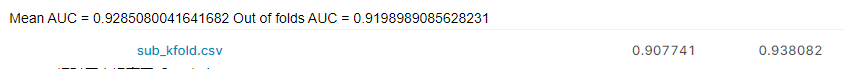

In [13]:
#X_test[cat]=X_test[cat].astype(np.int64)
y_pred=np.zeros(X_test.shape[0])
for clf in clfs:
    y_pred+=clf.predict_proba(X_test[cols])[:,1]/5
sub=pd.read_csv('sample_submission.csv')
sub['isFraud']=y_pred
sub.to_csv('.\submit\drop_V_C.csv',index=False)


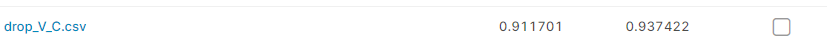 
线上分数，a榜跌b榜涨，也就还是lb和pb，有Public Leaderboard (LB)和 Private LB 之分。具体而言，参赛选手提交整个测试集的预测结果，Kaggle 使用测试集的一部分计算得分和排名，实时显示在 Public LB上，用于给选手提供及时的反馈和动态展示比赛的进行情况；测试集的剩余部分用于计算参赛选手的最终得分和排名，此即为 Private LB，在比赛结束后会揭晓。用于计算 Public LB 和 Private LB 的数据有不同的划分方式，具体视比赛和数据的类型而定，一般有随机划分，按时间划分或者按一定规则划分。大家可以合理利用Public Leaderboard的排名和反馈来适当调整自己的策略，但是不要太过依赖Public Leaderboard，有些时候它的数据分布和Private Leaderboard会有差异，不要在Public Leaderboard上过拟合。

这也是为什么我们常常说 要 trust your local cv，一个经验就是，如果你认为自己的操作是合乎逻辑的，那么千一到万一的a 榜波动不要太过在意，但是如果a榜分数变动了千七甚至超过百一，那么就要小心自己的原始思路是不是有问题。
为了更深刻的体会，后面的每一次local cv都会提交以对照a b 榜的变化

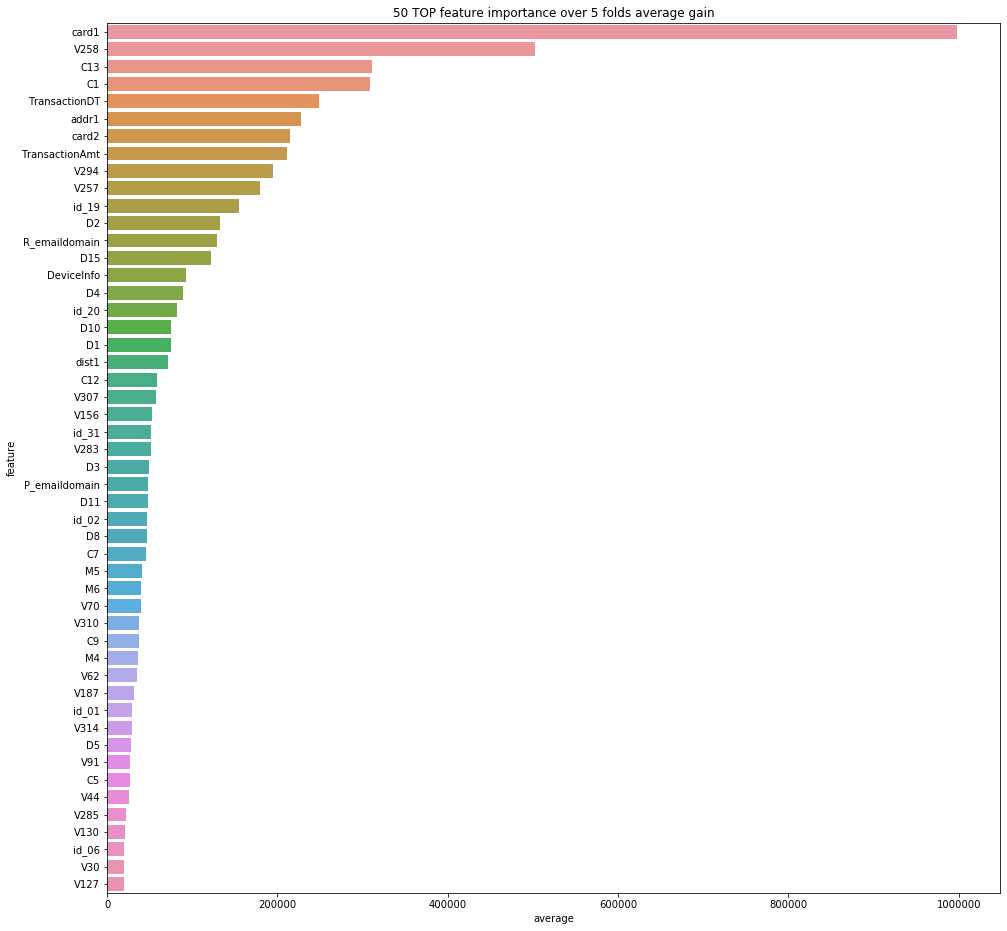

In [19]:
feature_imporatnces=get_imp(clfs,imp_type='gain',feature_names=cols)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_imporatnces.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average gain'.format(5));

## 过拟合问题的解决

显然，根据上面的训练结果，模型的过拟合问题严重

### 最简单直接快速的方法，使用更加严格的约束性参数,来看看和是否是由于模型复杂度太高引起的过拟合

In [50]:
params['max_depth']=5
params['subsample']=0.42
params['colsample_bytree']=0.38

In [51]:
clfs=lgb_model(params=params,cv=KFold(5),X=X,X_test=X_test,early_stopping_rounds=200,categorical_feature=cat)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.897713	valid_1's auc: 0.846752
[200]	training's auc: 0.91458	valid_1's auc: 0.861088
[300]	training's auc: 0.924222	valid_1's auc: 0.868573
[400]	training's auc: 0.930003	valid_1's auc: 0.873475
[500]	training's auc: 0.934491	valid_1's auc: 0.876497
[600]	training's auc: 0.938712	valid_1's auc: 0.879576
[700]	training's auc: 0.94159	valid_1's auc: 0.882562
[800]	training's auc: 0.944016	valid_1's auc: 0.884881
[900]	training's auc: 0.946014	valid_1's auc: 0.887007
[1000]	training's auc: 0.947908	valid_1's auc: 0.889346
[1100]	training's auc: 0.949508	valid_1's auc: 0.891195
[1200]	training's auc: 0.951027	valid_1's auc: 0.892693
[1300]	training's auc: 0.952483	valid_1's auc: 0.893945
[1400]	training's auc: 0.953836	valid_1's auc: 0.894866
[1500]	training's auc: 0.954986	valid_1's auc: 0.89535
[1600]	training's auc: 0.95632	valid_1's auc: 0.896386
[1700]	training's auc: 0.957322	valid_1's auc: 0.897181

[3700]	training's auc: 0.975343	valid_1's auc: 0.916352
[3800]	training's auc: 0.975899	valid_1's auc: 0.916462
[3900]	training's auc: 0.976413	valid_1's auc: 0.916526
[4000]	training's auc: 0.976899	valid_1's auc: 0.916625
[4100]	training's auc: 0.977436	valid_1's auc: 0.916781
[4200]	training's auc: 0.977877	valid_1's auc: 0.9168
[4300]	training's auc: 0.978301	valid_1's auc: 0.916924
[4400]	training's auc: 0.978773	valid_1's auc: 0.917067
[4500]	training's auc: 0.979203	valid_1's auc: 0.917119
[4600]	training's auc: 0.979565	valid_1's auc: 0.917166
[4700]	training's auc: 0.979871	valid_1's auc: 0.917168
[4800]	training's auc: 0.980317	valid_1's auc: 0.917235
[4900]	training's auc: 0.980649	valid_1's auc: 0.917301
[5000]	training's auc: 0.981072	valid_1's auc: 0.917445
[5100]	training's auc: 0.981426	valid_1's auc: 0.917529
[5200]	training's auc: 0.981733	valid_1's auc: 0.917603
[5300]	training's auc: 0.982033	valid_1's auc: 0.917664
[5400]	training's auc: 0.982419	valid_1's auc: 0.9

[2100]	training's auc: 0.964122	valid_1's auc: 0.903608
[2200]	training's auc: 0.96516	valid_1's auc: 0.904153
[2300]	training's auc: 0.966108	valid_1's auc: 0.904571
[2400]	training's auc: 0.966881	valid_1's auc: 0.904625
[2500]	training's auc: 0.967789	valid_1's auc: 0.905017
[2600]	training's auc: 0.968581	valid_1's auc: 0.905282
[2700]	training's auc: 0.969396	valid_1's auc: 0.905746
[2800]	training's auc: 0.970211	valid_1's auc: 0.906152
[2900]	training's auc: 0.970842	valid_1's auc: 0.906378
[3000]	training's auc: 0.971425	valid_1's auc: 0.906537
[3100]	training's auc: 0.971986	valid_1's auc: 0.906665
[3200]	training's auc: 0.972598	valid_1's auc: 0.906908
[3300]	training's auc: 0.973081	valid_1's auc: 0.906948
[3400]	training's auc: 0.973649	valid_1's auc: 0.907127
[3500]	training's auc: 0.974188	valid_1's auc: 0.90733
[3600]	training's auc: 0.974643	valid_1's auc: 0.907385
[3700]	training's auc: 0.975312	valid_1's auc: 0.907589
[3800]	training's auc: 0.975733	valid_1's auc: 0.9

In [52]:
params['max_depth']=3
params['subsample']=0.21
params['colsample_bytree']=0.19

In [53]:
clfs=lgb_model(params=params,cv=KFold(5),X=X,X_test=X_test,early_stopping_rounds=200,categorical_feature=cat)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.868029	valid_1's auc: 0.813835
[200]	training's auc: 0.881197	valid_1's auc: 0.828064
[300]	training's auc: 0.888493	valid_1's auc: 0.835387
[400]	training's auc: 0.89451	valid_1's auc: 0.842131
[500]	training's auc: 0.899866	valid_1's auc: 0.848599
[600]	training's auc: 0.904151	valid_1's auc: 0.853692
[700]	training's auc: 0.907342	valid_1's auc: 0.857705
[800]	training's auc: 0.910285	valid_1's auc: 0.861886
[900]	training's auc: 0.912744	valid_1's auc: 0.864835
[1000]	training's auc: 0.914681	valid_1's auc: 0.86747
[1100]	training's auc: 0.916402	valid_1's auc: 0.870377
[1200]	training's auc: 0.918087	valid_1's auc: 0.872087
[1300]	training's auc: 0.919739	valid_1's auc: 0.873896
[1400]	training's auc: 0.921322	valid_1's auc: 0.875355
[1500]	training's auc: 0.922709	valid_1's auc: 0.876569
[1600]	training's auc: 0.924011	valid_1's auc: 0.877866
[1700]	training's auc: 0.925137	valid_1's auc: 0.8791

[7100]	training's auc: 0.952817	valid_1's auc: 0.915933
[7200]	training's auc: 0.953167	valid_1's auc: 0.916124
[7300]	training's auc: 0.953477	valid_1's auc: 0.916163
[7400]	training's auc: 0.953723	valid_1's auc: 0.916201
[7500]	training's auc: 0.954053	valid_1's auc: 0.916291
[7600]	training's auc: 0.954368	valid_1's auc: 0.916349
[7700]	training's auc: 0.954667	valid_1's auc: 0.916438
[7800]	training's auc: 0.954945	valid_1's auc: 0.916583
[7900]	training's auc: 0.955189	valid_1's auc: 0.916612
[8000]	training's auc: 0.955457	valid_1's auc: 0.916653
[8100]	training's auc: 0.955736	valid_1's auc: 0.916724
[8200]	training's auc: 0.956029	valid_1's auc: 0.91687
[8300]	training's auc: 0.95631	valid_1's auc: 0.916962
[8400]	training's auc: 0.956592	valid_1's auc: 0.916983
[8500]	training's auc: 0.956835	valid_1's auc: 0.91704
[8600]	training's auc: 0.957104	valid_1's auc: 0.917103
[8700]	training's auc: 0.95736	valid_1's auc: 0.917196
[8800]	training's auc: 0.957688	valid_1's auc: 0.917

[1100]	training's auc: 0.91431	valid_1's auc: 0.908933
[1200]	training's auc: 0.916179	valid_1's auc: 0.910037
[1300]	training's auc: 0.917916	valid_1's auc: 0.910854
[1400]	training's auc: 0.919536	valid_1's auc: 0.911578
[1500]	training's auc: 0.920973	valid_1's auc: 0.912054
[1600]	training's auc: 0.922317	valid_1's auc: 0.912759
[1700]	training's auc: 0.923508	valid_1's auc: 0.913334
[1800]	training's auc: 0.924686	valid_1's auc: 0.913859
[1900]	training's auc: 0.925831	valid_1's auc: 0.914369
[2000]	training's auc: 0.926945	valid_1's auc: 0.9148
[2100]	training's auc: 0.927933	valid_1's auc: 0.915261
[2200]	training's auc: 0.928975	valid_1's auc: 0.915909
[2300]	training's auc: 0.929782	valid_1's auc: 0.916248
[2400]	training's auc: 0.930507	valid_1's auc: 0.916574
[2500]	training's auc: 0.931404	valid_1's auc: 0.916973
[2600]	training's auc: 0.932148	valid_1's auc: 0.917255
[2700]	training's auc: 0.932885	valid_1's auc: 0.917464
[2800]	training's auc: 0.933616	valid_1's auc: 0.91

[5500]	training's auc: 0.94947	valid_1's auc: 0.893665
[5600]	training's auc: 0.949749	valid_1's auc: 0.893761
[5700]	training's auc: 0.950066	valid_1's auc: 0.893874
[5800]	training's auc: 0.950422	valid_1's auc: 0.894103
[5900]	training's auc: 0.950781	valid_1's auc: 0.894347
[6000]	training's auc: 0.951113	valid_1's auc: 0.894565
[6100]	training's auc: 0.951441	valid_1's auc: 0.894607
[6200]	training's auc: 0.951768	valid_1's auc: 0.894654
[6300]	training's auc: 0.952176	valid_1's auc: 0.894904
[6400]	training's auc: 0.952567	valid_1's auc: 0.895012
[6500]	training's auc: 0.952884	valid_1's auc: 0.895194
[6600]	training's auc: 0.953179	valid_1's auc: 0.895313
[6700]	training's auc: 0.953523	valid_1's auc: 0.895386
[6800]	training's auc: 0.953867	valid_1's auc: 0.895571
[6900]	training's auc: 0.954204	valid_1's auc: 0.895653
[7000]	training's auc: 0.954539	valid_1's auc: 0.895827
[7100]	training's auc: 0.954875	valid_1's auc: 0.895934
[7200]	training's auc: 0.955121	valid_1's auc: 0.

使用了两组约束性逐渐变强的参数设置，可以发现虽然泛化误差下降了，但却是以模型的拟合能力降低为代价的，模型在验证集上的表现反而还不如原来，所以最终的local cv反而降低了，调参本身没有引入新的信息，只不过让模型以不同的强度去学习数据中的映射规则，可以看到验证集上的分数丝毫没有提升反而降低，说明调参并没有使得模型学习到更多新的东西来预测未知的数据，特征工程的上限没有被突破，我们的调参只不过是在特征工程的界限上的反复震荡；

当然，实际上我们使用kaggle上的大佬已经调整的参数来训练还是能提升一些成绩的，但是问题是意义可能并不是太大，因为后期加入很多新的特征或者删除新的特征，模型的最优参数可能又要发生变化，而调整耗费的时间是非常长久的，很不划算，所以不如先保持参数不变，在特征工程上进行深入的挖掘；

另一方面，有针对性的复杂调参和使用一些kaggle的“祖传”参数设置，在最终的结果上差异性并不会特别大，这里泛化误差超过7个点以上，基本不可能仅仅通过调参的方式就能解决，也就是说我们使用一些kaggle上非常常用的参数组合或者是baseline里作者使用的一些参数设置在初期就够用了，tabular数据99%以上胜在特征而不是超参数的调整。因此我们需要转换思考的角度来解决过拟合的问题

### 从样本的角度，删除一些对模型影响比较大的异常样本，但实际上很少有人在tabular比赛中这么做，主要原因有：
1、异常检测算法对于gbdt系列算法压根不太使用，也就是常规的异常检测算法得到的异常样本并不一定是影响gbdt训练的样本；
2、大部分异常检测算法的实施都是非常麻烦的，一方面类别特征很多的情况下需要对类别做编码或者使用kprototype这样的混合无监督的方式来做，并且大部分异常检测算法特别是涉及到密度或者距离计算的算法计算复杂度很高，计算的时间非常长；
3、对于异常样本的定义往往是不明确的，人为定义的异常样本常常对模型来说是正常样本；
4、存在一部分噪声样本可以在某种程度上提高模型的鲁棒性；
真正需要对样本进行处理的一般就是典型的不均衡问题条件下，可能需要做一些处理（不一定要做，比如这个比赛就需不要做不平衡处理，做了反而效果差了非常多，具体原因后面总结）

综上，放弃从样本的角度进行处理，实际上在各类比赛中也比较少见这种通过检测异常样本的方式来提高local cv 的

### 从特征工程的角度，实际上过拟合的本质原因是不同数据集的数据分布的差异性，无论是部分异常样本引起的分布差异性还是模型复杂度太高从而太“完美”的捕捉到不同数据集之间微小的分布差异，其本普适的内在映射关系；但是如果分布差异性非常大，比如我们目前遇到的这个数据集，那么通过简单的使用更加严格的限制性参数是收效甚微的，甚至会导致欠拟合，这一点我们通过上面的两个测试就可以看出来；

最快的一键测试分布偏移的方式是使用对抗性验证，和大佬kris的时间一致性验证法及其变体，二者可以搭配使用，

#### 对抗性验证



前面我们已经讨论过，7个点以上的高泛化误差在过去的比赛中基本上不可能见到通过调参数来得到很好的改善，要从根本（特征分布偏移）上去解决问题，那么
首先我们需要检验可能是哪些特征的偏移导致了local cv的高泛化误差以及检查训练集和测试集之间的分布差异性，这里我们需要用到两个方法：
1、对抗性验证；
2、kaggle大佬kris使用的时间验证 的 改进版

对抗性验证就是把训练集标签设为1，测试集设为0，然后训练一个（或者进行交叉验证）lightgbm，通过观察auc的大小来判断训练集与测试集这两个数据集的分布的差异性程度，并且通过特征重要性的方式来观察具体是哪些特征带来了比较大的特征偏移；对抗性验证可以帮助我们判断训练集与测试集的分布差异性的程度，但是如何去解决特征分布偏移的问题从而提高local cv的结果，直接依赖于对抗性验证并不是最好最合适的方法，很多时候效果并不好，因为对抗性验证是基于训练集和测试集的验证，而local cv纯粹是使用训练集进行训练，也就是说对抗性验证找到的偏移特征并不一定是影响 local cv 的偏移特征，所以一般对抗性验证主要用于测试训练集与测试集的偏离程度，以及查找一些偏移特别严重的特征，而具体怎么通过对偏移特征的处理来提高local cv的方案还需要使用到kaggle 大佬kris使用的时间验证的扩展版。

kris在kaggle_ieee比赛中使用time consistency的方法很容易扩展到更广的方向（具体介绍可见：https://www.kaggle.com/c/ieee-fraud-detection/discussion/111308），我通过将这种验证方法的交叉验证的方式改成我线下local cv的交叉验证的方式进行测试和特征选择，可以非常直观并且易于理解的对特征进行选择，思路也不难，就是把你的每一个特征单独的跑一个你的lgb或者是xgb模型，然后通过交叉验证的auc结果来判断这个特征的分布是否发生偏移并且可以通过训练集与验证集的auc的差值来定量的衡量特征的偏移程度

下面我们首先进行对抗性验证

In [ ]:
y=[1,2,3,4,5,6]
X=[0.01,0.1,1,10,100]

In [20]:
lgb_params = {
        'boosting': 'gbdt',
        'application': 'binary',
        'metric': 'auc', 
        'learning_rate': 0.1,
        'num_leaves': 32,
        'max_depth': 8,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'n_estimators':1000
}
X['is_train']=1
X_test['is_train']=0

# Get folds for k-fold CV
df=pd.concat([X,X_test])
df[cat]=df[cat].astype('category')
df.index=list(range(df.shape[0]))
y=df.pop('is_train')


In [21]:
X.drop('is_train',axis=1,inplace=True)
X_test.drop('is_train',axis=1,inplace=True)

In [22]:
Clfs=lgb_model(params=lgb_params ,cv=StratifiedKFold(n_splits = 5, random_state = 123),X=df,y=y,early_stopping_rounds=100, \
               cols=cols,categorical_feature=cat,group_feature=None)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[32]	training's auc: 0.999998	valid_1's auc: 1
Fold 1 | AUC: 1.0
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 0.999996	valid_1's auc: 1
Fold 2 | AUC: 1.0
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 0.999996	valid_1's auc: 1
Fold 3 | AUC: 1.0
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[1]	training's auc: 0.999996	valid_1's auc: 1
Fold 4 | AUC: 1.0
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 1	valid_1's auc: 0.998399
Early stopping, best iteration is:
[2]	training's auc: 0.999999	valid_1's auc: 1


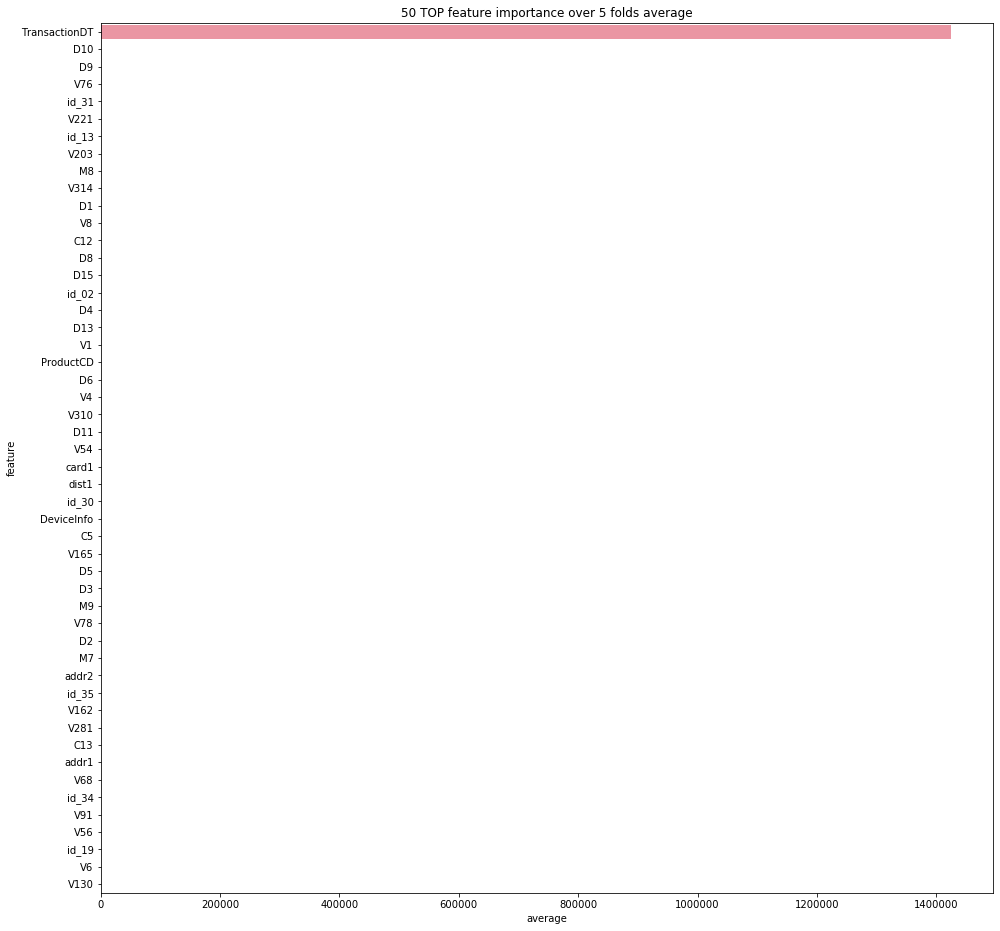

In [23]:
feature_importances=get_imp(Clfs,'gain',list(df.columns))
plt.figure(figsize=(16,16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(5));

从这里可以看出TrsanctionDT发生严重的偏移

但是实际上我们在eda的阶段也看到了一些特征在训练集和测试集上分布存在较大的差异性，这些特征也发生了严重的偏移只不过偏移程度没有TransactionDT那么严重，从这里我们明显可以看到对抗性验证实际上也是特征重要性的不足之处：

第一个不足之处：也是feature importance这种特征重要性衡量方式的本身的缺陷，很多时候如果特征中存在很强的特征，那么其它也不错但是相对不那么强的特征的重要性就很可能被cover掉，这里是一个比较极端的例子，被全部cover掉了。 这里我们把TransactionDT remove掉然后再看看结果

显然，这种时间特征没法使用，完全偏移，测试集和训练集的范围都是完全不同的，模型压根没法使用这种特征

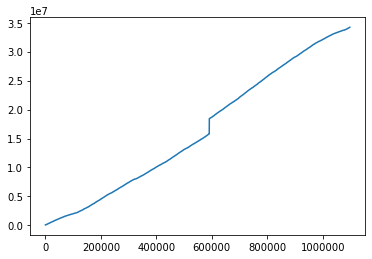

In [219]:
plt.plot(df.TransactionDT)

In [13]:
cols=list(df.columns)
cols.remove('TransactionDT')#删除太强的transactiondt然后看看其它特征的情况
Clfs=lgb_model(params=lgb_params,cv=StratifiedKFold(n_splits = 5, random_state = 123),X=df,y=y,early_stopping_rounds=100, \
               cols=cols,categorical_feature=cat,group_feature=None)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.901144	valid_1's auc: 0.981991
Early stopping, best iteration is:
[94]	training's auc: 0.899885	valid_1's auc: 0.982272
Fold 1 | AUC: 0.982272396779908
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.926458	valid_1's auc: 0.890492
[200]	training's auc: 0.939863	valid_1's auc: 0.902083
[300]	training's auc: 0.948947	valid_1's auc: 0.908479
[400]	training's auc: 0.954456	valid_1's auc: 0.911766
[500]	training's auc: 0.95939	valid_1's auc: 0.914475
[600]	training's auc: 0.962704	valid_1's auc: 0.916607
[700]	training's auc: 0.96582	valid_1's auc: 0.91801
[800]	training's auc: 0.968312	valid_1's auc: 0.918872
[900]	training's auc: 0.970578	valid_1's auc: 0.919388
[1000]	training's auc: 0.972304	valid_1's auc: 0.920011
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.972304	valid_1's auc: 0.920011
Fold 2 | AUC: 0.9200108026712854
Training until 

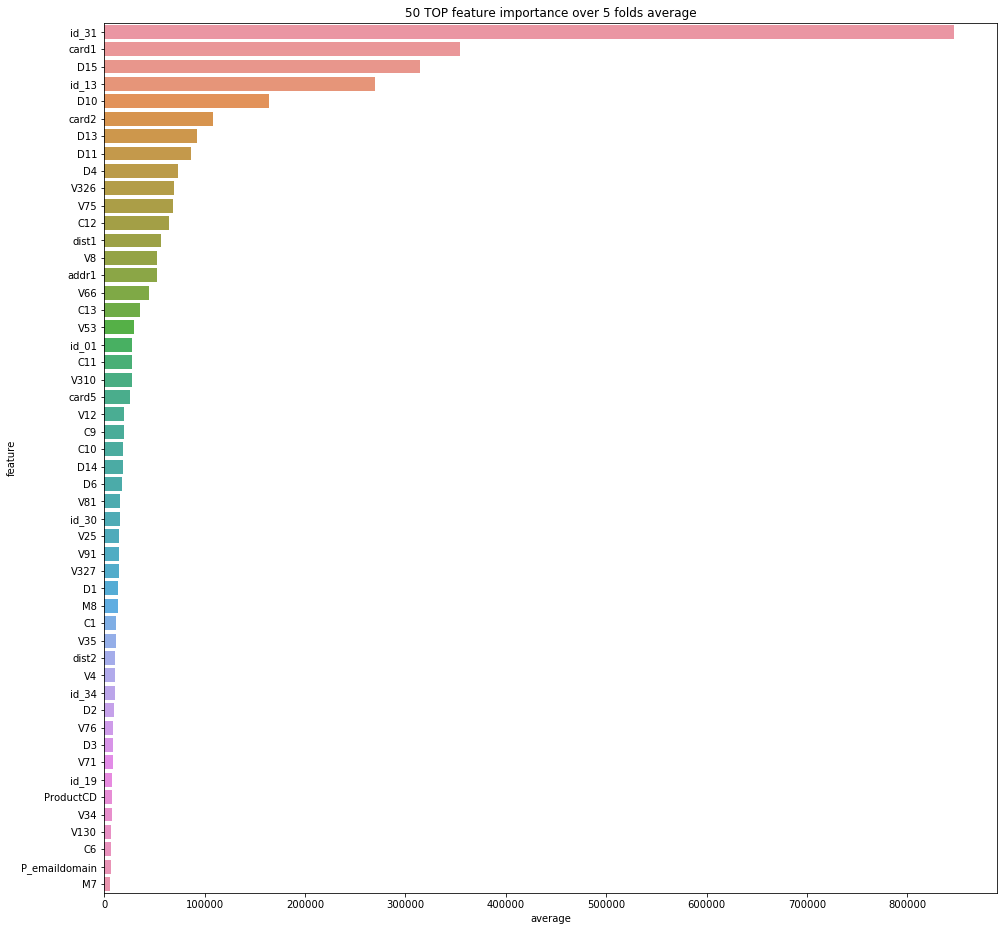

In [16]:
feature_importances=get_imp(Clfs,'gain',cols)
feature_importancesfeature_importances=get_imp(Clfs,'gain',cols)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(5));


和我们之前做baseline得到的特征重要性图比较一下就会发现有意思的事情
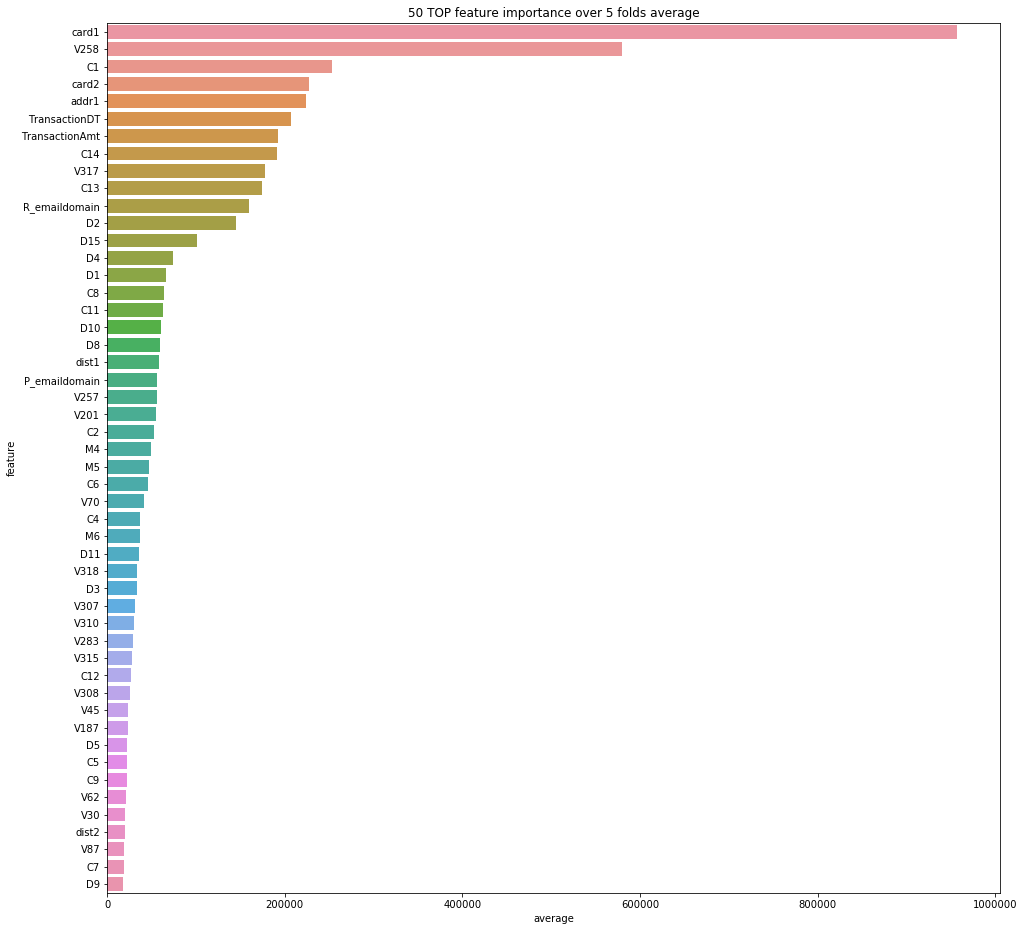

我们可以看到，对抗性验证中贡献度很高的特征有很多强特实际上也是正常训练得到的特征重要性中排名靠前的，所以我们找到了导致过拟合的一个重要原因，对好坏客户区分度高的特征card1、card2、addr1等本身的特征偏移也较严重，这些不同的特征如果在分裂的时候互相叠加则组合特征的偏移就更加严重了

在remove完TransactionDT之后，我们可以看到重新训练的对抗性验证中card1，card2的偏移也很严重，但是发现remove完TransactionDT后local cv分数上升了一些，但是删除了card1之后分数大大下降了，而card1和transactionDT在特征重要性中排名都不错，所以问题就来了，这到底实什么原因？

原因就是TransactionDT是一个偏移严重并且对于未知数据的预测能力为0的垃圾特征，而card1虽然也发生偏移，但是card1具有较强的区分能力，那么为了辨别出特征的这种性质我们就要使用新的方法

#### kris验证法

下面介绍新的验证方法，想不到名字暂时称之为kris验证法吧，因为是kaggle大佬kris在介绍的时候使用的，我做了一些改变
https://www.kaggle.com/c/ieee-fraud-detection/discussion/111308 之前在自己的代码里加入了这个方法发现效果不太好，后来根据自己的交叉验证方式重新改变之后，非常直观方便
##### 整体的思路就是每一个特征单独进行交叉验证，然后比较训练集与测试集的评价指标的误差，这样就能很快速的对于每一个特征独立的评价了
需要注意，这里的交叉验证方式要与loca cv使用的交叉验证的方式一致效果最佳

In [25]:
X[cat]=X[cat].astype('category')

In [19]:
del df,y
gc.collect()
y=pd.read_csv('y.csv')
y=y.y

In [74]:
result=[]
cols=list(X.columns)
X['nouse']=0 #lgb无法在单特征上训练(会报错)所以使用一个nouse特征避免错误，因为是常数特征值全都一样所以
#不用担心影响模型训练过程，模型完全不会在nouse特征上训练的
flag=0
for col in ['dels']:#cols:
    folds=KFold(5)

    splits = folds.split(X[col], y)


    for fold_n, (train_index, valid_index) in enumerate(splits):
        X_train, X_valid = X[[col,'nouse']].iloc[train_index], X[[col,'nouse']].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]


        clf = lgb.LGBMClassifier(n_estimators=500, objective='binary', 
                num_leaves=491, learning_rate=0.02,n_jobs=-1,max_depth=-1)
        h = clf.fit(X_train, y_train, eval_metric='auc', 
                eval_set=[(X_train,y_train),(X_valid,y_valid)],verbose=-1)

        auc_train = np.round(h._best_score['training']['auc'],4)
        auc_val = np.round(h._best_score['valid_1']['auc'],4)
        result.append([flag,auc_train,auc_val,auc_train-auc_val])

        del X_train, X_valid, y_train, y_valid,clf
        gc.collect()
    flag+=1
X.pop('nouse')
result=pd.DataFrame(result,columns=['flag','train_auc','valid_auc','auc_delta'])
results=pd.DataFrame()
results['mean']=results.groupby('flag')['train_auc','valid_auc','auc_delta'].apply(np.mean)
results['min']=results.groupby('flag')['train_auc','valid_auc','auc_delta'].apply(np.min)
results['max']=results.groupby('flag')['train_auc','valid_auc','auc_delta'].apply(np.max)
results['feature']=cols
results.to_csv('.\output\kfold_kris_feature_distribution_test.csv',index=False)

在groupkfold的验证方式下也做一下kris验证：

In [36]:
dtm=pd.read_csv('X_DT_M.csv')
X['DT_M']=dtm.month.values

In [79]:
result=[]
cols=list(X.columns)
cols.remove('DT_M')
X['nouse']=0 #lgb无法在单特征上训练(会报错)所以使用一个nouse特征避免错误，因为是常数特征值全都一样所以
#不用担心影响模型训练过程，模型完全不会在nouse特征上训练的

flag=0
for col in cols:
    folds=GroupKFold(5)

    splits = folds.split(X[col],y,X.DT_M)


    for fold_n, (train_index, valid_index) in enumerate(splits):
        X_train, X_valid = X[[col,'nouse']].iloc[train_index], X[[col,'nouse']].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]


        clf = lgb.LGBMClassifier(n_estimators=500, objective='binary', 
                num_leaves=491,max_depth=-1, learning_rate=0.02,n_jobs=-1,max_depth=-1)
        h = clf.fit(X_train, y_train, eval_metric='auc', 
                eval_set=[(X_train,y_train),(X_valid,y_valid)],verbose=-1)

        auc_train = np.round(h._best_score['training']['auc'],4)
        auc_val = np.round(h._best_score['valid_1']['auc'],4)
        result.append([flag,auc_train,auc_val,auc_train-auc_val])

        del X_train, X_valid, y_train, y_valid,clf
        gc.collect()
    flag+=1
X.pop('nouse')
results=pd.DataFrame(result,columns=['flag','train_auc','valid_auc','auc_delta'])



下面就介绍一下验证的结果如何使用，以kfold的kris验证结果为例：
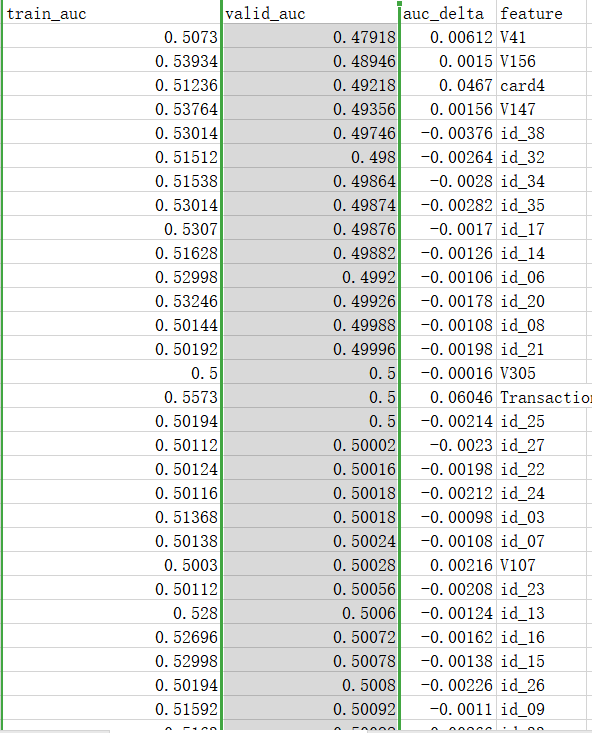

首先我们会得到这么一张表，train_auc表示对应的feature的交叉验证训练集auc的均值，test_auc表示对应的feature的交叉验证的验证集的auc的均值，auc_delta是二者的差值

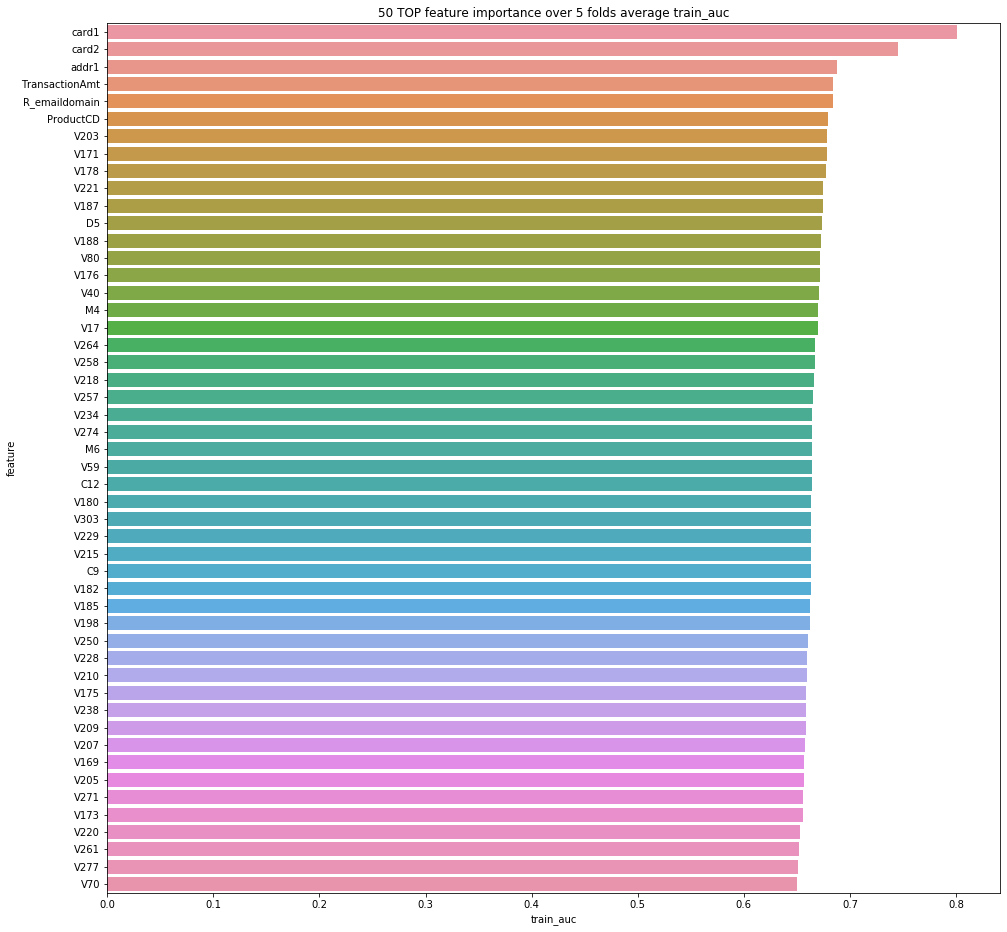

In [53]:
plt.figure(figsize=(16, 16))
sns.barplot(data=results.sort_values(by='train_auc', ascending=False).head(50), x='train_auc', y='feature');
plt.title('50 TOP feature importance over {} folds average train_auc'.format(5));

对比一下之前用baseline建立的模型得到的feture_importance图，可以看到baseline里，特征贡献度最高的特征之中有很多是train_aua最高的特征，实际上，使用kris的这种验证方法的精髓在于独立的充分挖掘每一个特征的分裂能够为训练集和测试集带来的贡献，并且以我们关心的评价指标的形式展现，这样就可以很直观的看出每一个特征相对于评价指标auc的重要程度。我们前面做对抗性验证的时候提到过feature importance的缺点，就是当某些特征太强的时候，会cover到其它的一些虽然不错但是相对没那么强的特征，所以实际上feature importance反映的信息是有限的，它会遗漏不少有用的信息

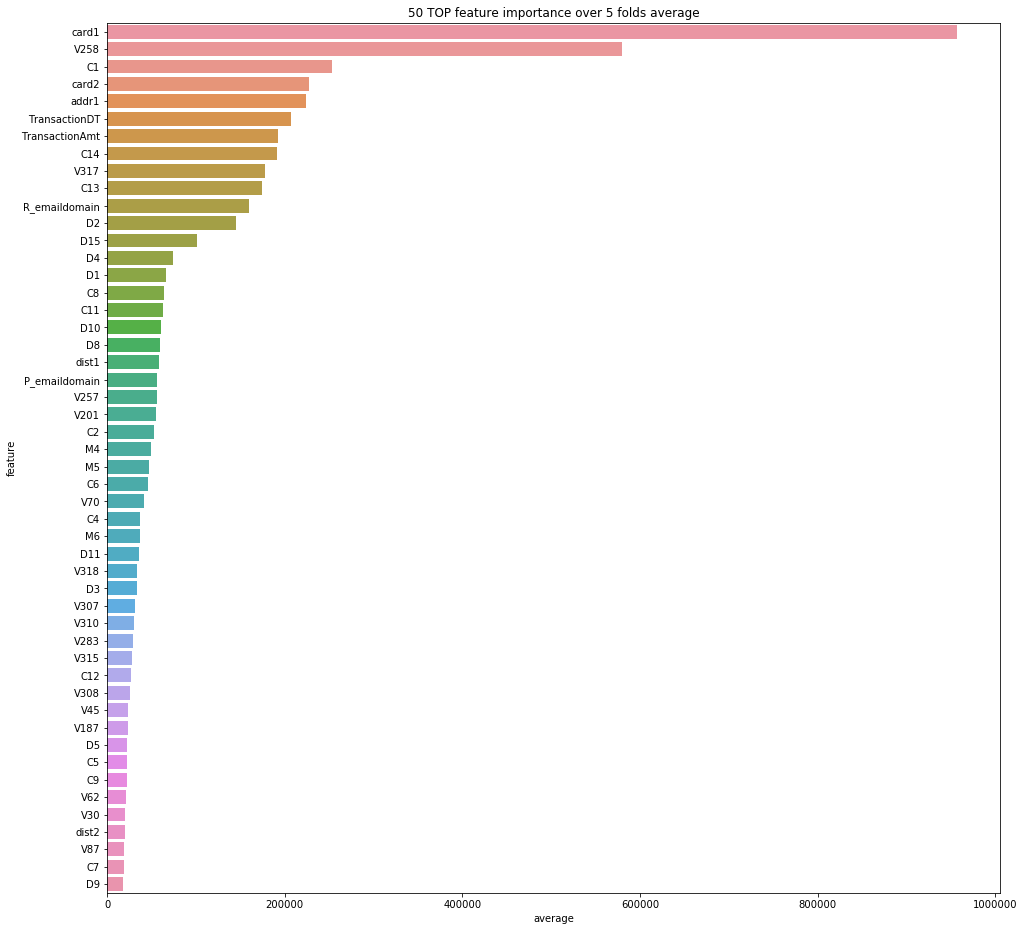

再看看delta auc的排列情况

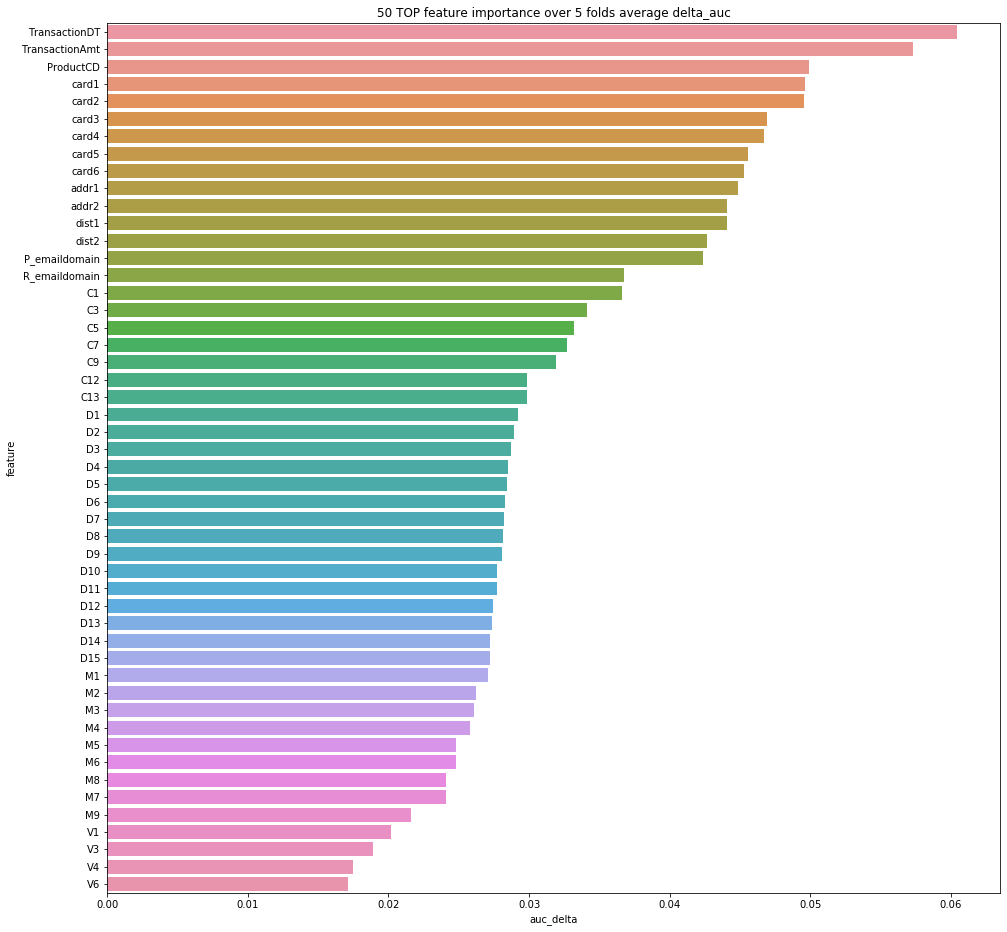

In [54]:

plt.figure(figsize=(16, 16))
sns.barplot(data=results.sort_values(by='auc_delta', ascending=False).head(50), x='auc_delta', y='feature');
plt.title('50 TOP feature importance over {} folds average delta_auc'.format(5));

根据delta auc的结果，有很多类别特征都发生了较为严重的偏移card系列，email系列等都属于top级别的偏移特征,也有很多连续特征发生了严重偏移，比如C系列的特征占了一大堆。。。。。这里的针对偏移特征的解决方案有：
1、直接删除但会造成一定的信息损失；
2、对于偏移严重的类别特征，尝试将其转化为连续值，kaggle trick；
3、对于偏移严重的连续特征，尝试使用对数变换、分箱等方法降低偏移程度；
4、如果选择直接删除，记得要看看能不能从要删除的特征，尤其是类别特征中做一些特征抽取的工作，比如类别特征做特征编码之后再删除或者是kaggle经典的特征衍生方法——groupby。。。。等


首先我们要删除在validation上auc为0.50及以下的特征，这类特征在训练集上学到的规则对于验证集帮助很低；其次，card系列中的很多强特虽然偏移但是本身的区分度也很高对于区分好坏客户也发挥重要的贡献，对于这类特征我们先使用frequent encode进行特征提取，然后选择删除或者转化为连续值；对于连续特征我们则实施对数变换。TransactionDT这样的特征无可救药，直接删除。

#### 下面分别尝试不同的方案

根据kris验证的结果先删除在validation上auc很低的，这其中包括对抗性验证中得到的TransactionDT，阈值切到0.5,可以看到这部分特征：
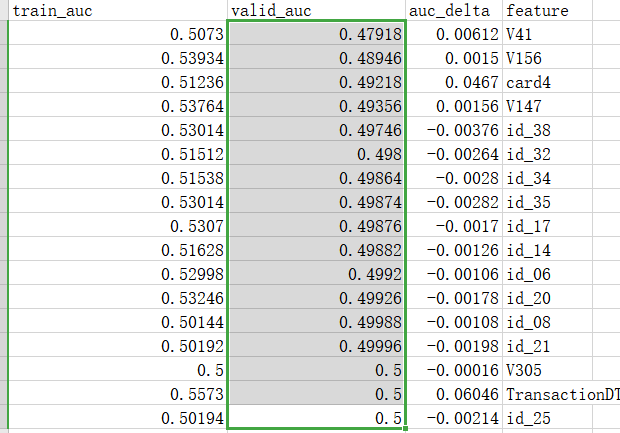

在train 部分贡献了微弱的auc，在valid部分贡献的auc小于等于0.5，也就是说模型能够在这些特征上学习到的模式对于预测未来数据完全 没有帮助，因此这部分特征可以先剔除。

In [60]:
kris_drops=results.loc[results.valid_auc<=0.5,'feature'].values.tolist()

这个比赛的一个得分点也是这个kaggle trick，就是类别转连续，要把类别转连续我们首先要对类别进行label encoder，缺失值用编码-1代替。

In [58]:
for col in cat:
    encode_LE(col,X,X_test)

ProductCD , card1 , card2 , card3 , card4 , card5 , card6 , addr1 , addr2 , M1 , M2 , M3 , M4 , M5 , M6 , M7 , M8 , M9 , id_12 , id_13 , id_14 , id_15 , id_16 , id_17 , id_18 , id_19 , id_20 , id_21 , id_22 , id_23 , id_24 , id_25 , id_26 , id_27 , id_28 , id_29 , id_30 , id_31 , id_32 , id_33 , id_34 , id_35 , id_36 , id_37 , id_38 , DeviceType , DeviceInfo , P_emaildomain , R_emaildomain , 

##### 1、直接把类别当作连续特征，并删除无用特征

In [61]:
cols=list(X.columns)
for col in kris_drops:
    cols.remove(col)
cols.remove('TransactionDT')
clfs=lgb_model(params=params,cv=KFold(5),X=X,y=y,early_stopping_rounds=200,cols=cols,categorical_feature=None,group_feature=None)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.945462	valid_1's auc: 0.880376
[200]	training's auc: 0.961573	valid_1's auc: 0.890142
[300]	training's auc: 0.975825	valid_1's auc: 0.897233
[400]	training's auc: 0.984762	valid_1's auc: 0.903774
[500]	training's auc: 0.989894	valid_1's auc: 0.907569
[600]	training's auc: 0.99308	valid_1's auc: 0.909777
[700]	training's auc: 0.995097	valid_1's auc: 0.911218
[800]	training's auc: 0.996448	valid_1's auc: 0.911986
[900]	training's auc: 0.997343	valid_1's auc: 0.912724
[1000]	training's auc: 0.99799	valid_1's auc: 0.912792
[1100]	training's auc: 0.998453	valid_1's auc: 0.912702
Early stopping, best iteration is:
[979]	training's auc: 0.997854	valid_1's auc: 0.912862
Fold 1 | AUC: 0.912862262995865
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.944579	valid_1's auc: 0.902975
[200]	training's auc: 0.961372	valid_1's auc: 0.911765
[300]	training's auc: 0.975463	valid_1'


Mean AUC = 0.9285080041641682
Out of folds AUC = 0.9198989085628231
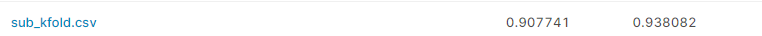
local cv相对原来提高了千1.5左右

In [63]:
#X_test[cat]=X_test[cat].astype(np.int64)
y_pred=np.zeros(X_test.shape[0])
for clf in clfs:
    y_pred+=clf.predict_proba(X_test[cols])[:,1]/5
sub=pd.read_csv('sample_submission.csv')
sub['isFraud']=y_pred
sub.to_csv('.\submit\just_cat2int.csv',index=False)

线上得分为：


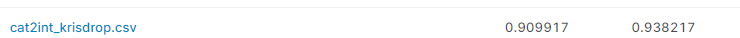
难得，a、b榜都提高了万2


##### 2、类别转连续，但不删除根据kris验证法得到的无用特征

In [65]:
cols=list(X.columns)
cols.remove('TransactionDT')#删除太强的transactiondt然后看看其它特征的情况
clfs=lgb_model(params=params,cv=KFold(5),X=X,y=y,early_stopping_rounds=200,cols=cols,categorical_feature=None,group_feature=None)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.945638	valid_1's auc: 0.87929
[200]	training's auc: 0.961524	valid_1's auc: 0.890308
[300]	training's auc: 0.975669	valid_1's auc: 0.897355
[400]	training's auc: 0.984853	valid_1's auc: 0.905054
[500]	training's auc: 0.990082	valid_1's auc: 0.909505
[600]	training's auc: 0.993258	valid_1's auc: 0.912034
[700]	training's auc: 0.995276	valid_1's auc: 0.913449
[800]	training's auc: 0.996551	valid_1's auc: 0.914321
[900]	training's auc: 0.997409	valid_1's auc: 0.914796
[1000]	training's auc: 0.998015	valid_1's auc: 0.914876
[1100]	training's auc: 0.998459	valid_1's auc: 0.914808
Early stopping, best iteration is:
[989]	training's auc: 0.997952	valid_1's auc: 0.914927
Fold 1 | AUC: 0.914927259881621
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.94514	valid_1's auc: 0.903979
[200]	training's auc: 0.961836	valid_1's auc: 0.912453
[300]	training's auc: 0.975978	valid_1'

In [66]:
#X_test[cat]=X_test[cat].astype(np.int64)
y_pred=np.zeros(X_test.shape[0])
for clf in clfs:
    y_pred+=clf.predict_proba(X_test[cols])[:,1]/5
sub=pd.read_csv('sample_submission.csv')
sub['isFraud']=y_pred
sub.to_csv('.\submit\cat2int.csv',index=False)

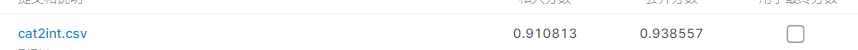

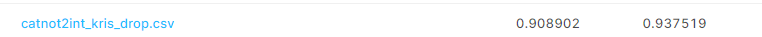

在另一台机器上跑了cat转化为int之后的kris验证，结果如下:

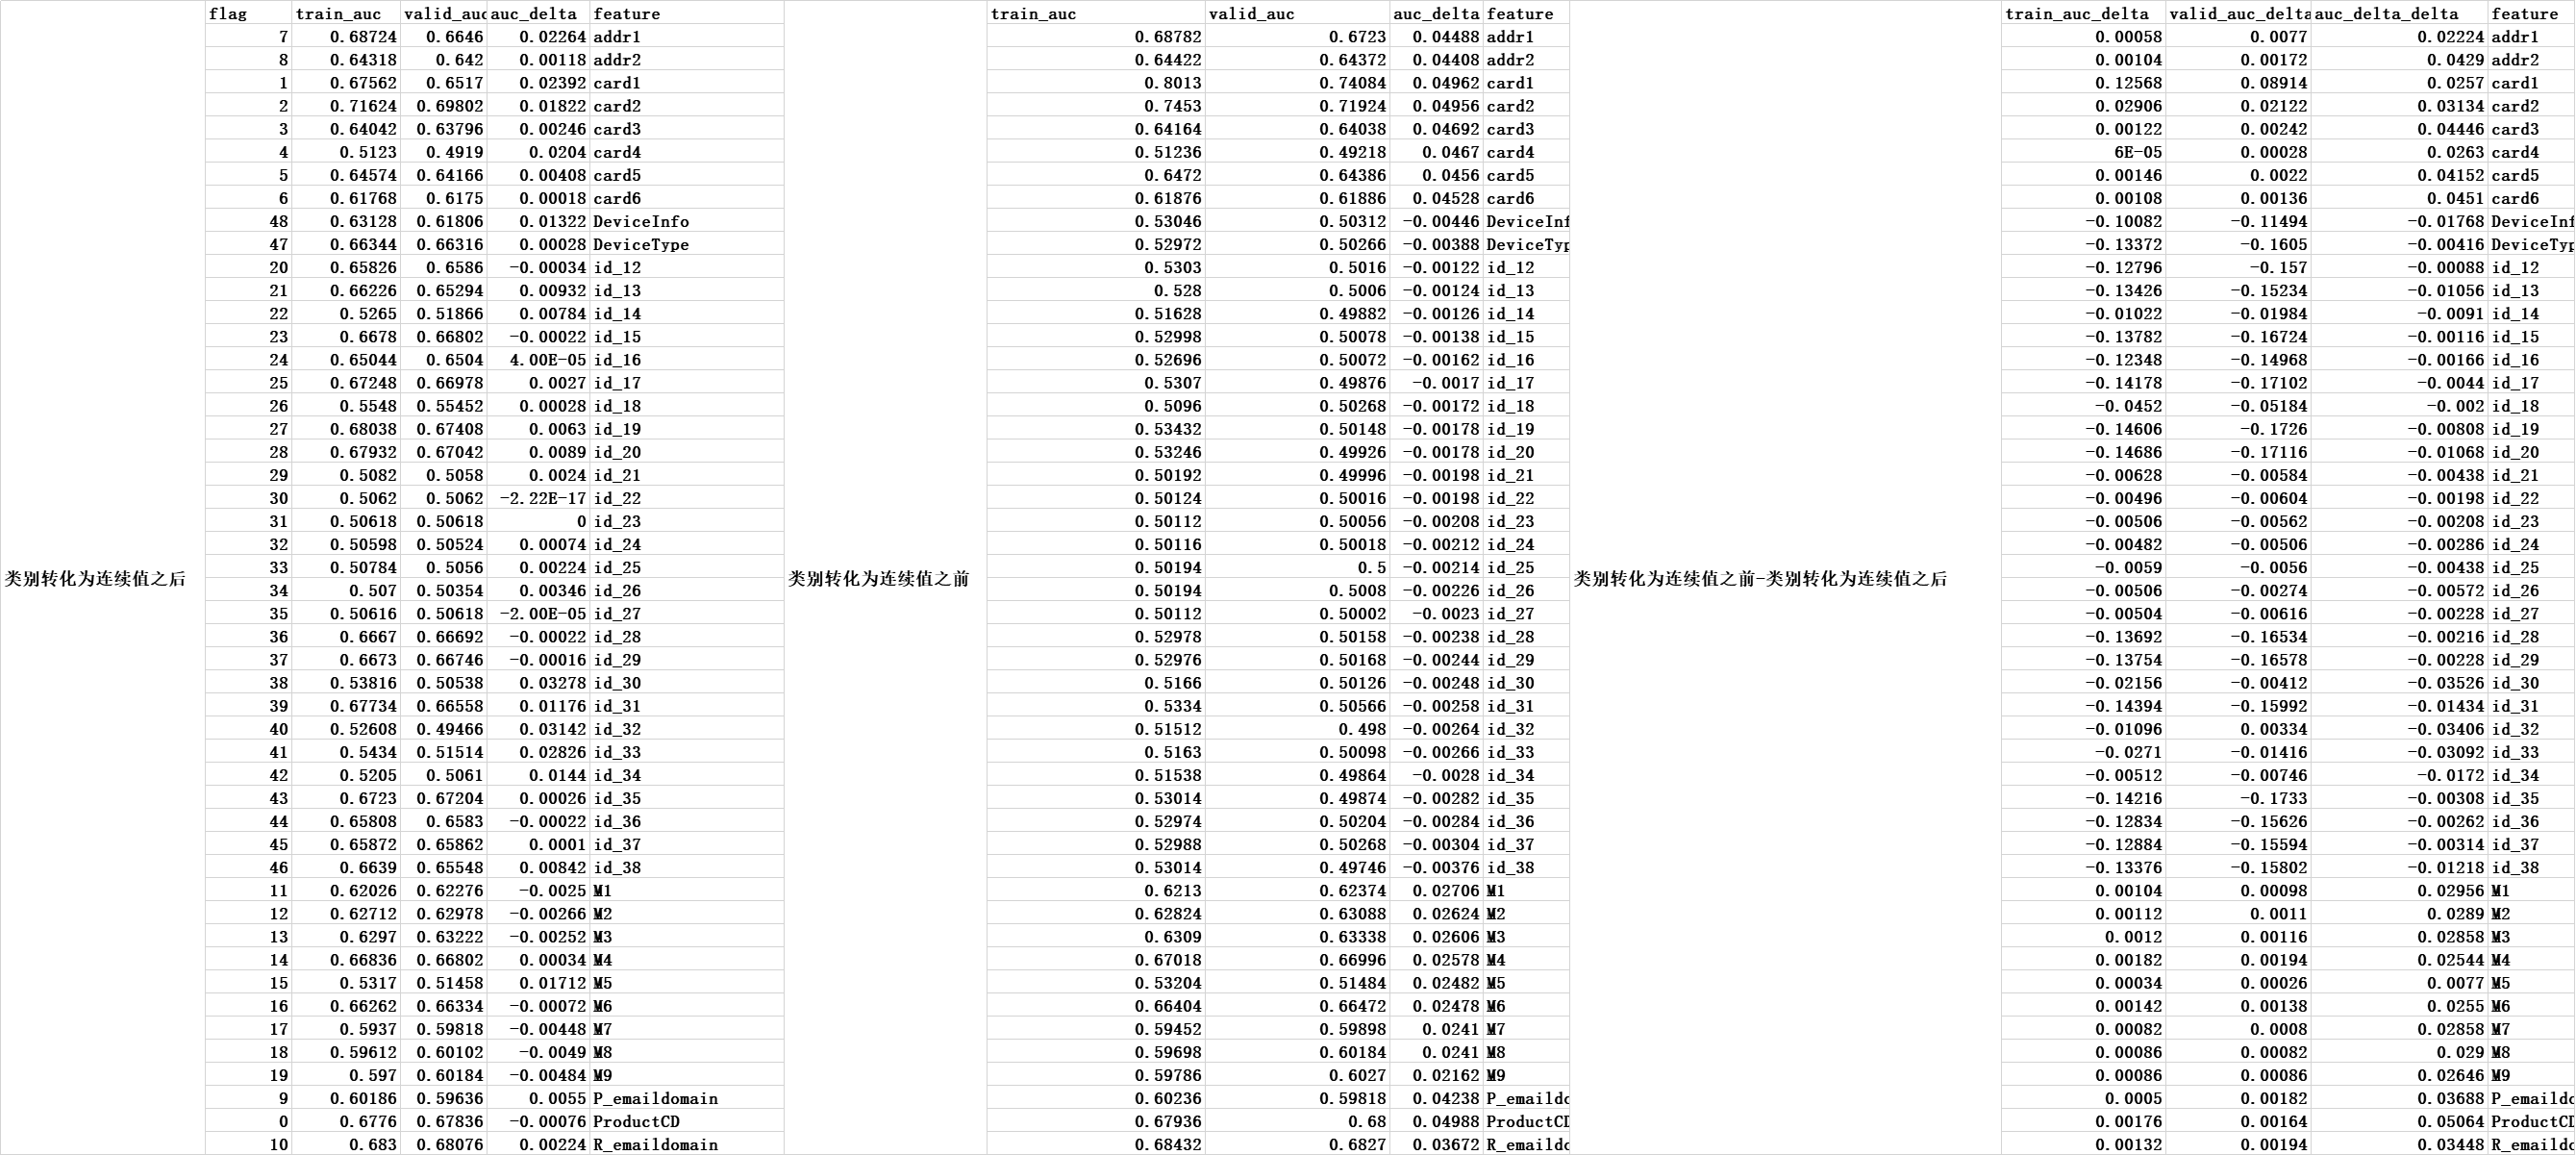

可以看到，除了card1牺牲了不少精度但是泛化误差下降了一半，card2也牺牲了一点点的精度但泛化误差也下降了不少，其他类别都是极微小的改变，可以看出，类别特征转化为int之后大部分对于lgb来说影响不大（主要原因是因为大部分类别特征的类别数量不多，lgb在连续和类别上的切分点差异性小，但是对于card1这样类别上万的特征来说影响就比较大了）；

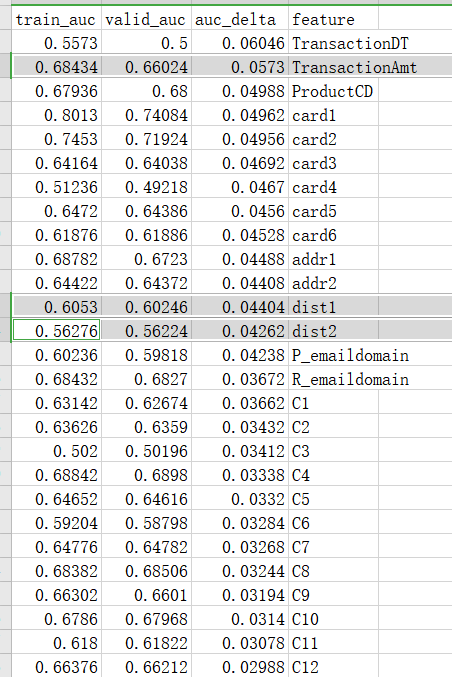
如上图，我们通过类别转int已经将所有的类别的泛化误差auc降低到了合适的水平，剩下的偏移最严重的连续特征中，TransactionDT偏移太严重直接删除

#### 连续值的偏移，分箱或者对数变换，例如这里的transactionamt和dist1与dist，尝试下看看效果,分箱太麻烦了，之前有听说可以做分箱提高一些的，没尝试觉得麻烦，简单用对数变换尝试了一下

In [88]:
X['log_transactionamt']=np.log1p(X.TransactionAmt)
X['log_dist1']=np.log1p(X.dist1)
X['log_dist2']=np.log1p(X.dist2)

In [100]:
X_test['log_transactionamt']=np.log1p(X_test.TransactionAmt)
X_test['log_dist1']=np.log1p(X_test.dist1)
X_test['log_dist2']=np.log1p(X_test.dist2)

In [97]:
cols=['log_transactionamt','log_dist1','log_dist2']:
result=kris_feature_select(cols=cols,X=X,y=y,cv=KFold(5),params=None)

In [93]:
for col in ['train_auc','valid_auc','auc_delta']:
    results['mean_'+col]=result.groupby('flag')[col].apply(np.mean)
for col in ['train_auc','valid_auc','auc_delta']:
    results['min_'+col]=result.groupby('flag')[col].apply(np.min)
for col in ['train_auc','valid_auc','auc_delta']:
    results['max_'+col]=result.groupby('flag')[col].apply(np.max)
results['feature']=['log_transactionamt','log_dist1','log_dist2']

In [94]:
results

,mean_train_auc,mean_valid_auc,mean_auc_delta,min_train_auc,min_valid_auc,min_auc_delta,max_train_auc,max_valid_auc,max_auc_delta,feature
0,0.71928,0.68008,0.0392,0.7140,0.6267,0.0179,0.7277,0.7004,0.1010,log_transactionamt
1,0.61778,0.60058,0.0172,0.6123,0.5464,-0.0051,0.6319,0.6174,0.0855,log_dist1
2,0.56938,0.55408,0.0153,0.5655,0.5448,0.0007,0.5722,0.5648,0.0274,log_dist2


和变换之前对比可以看到：
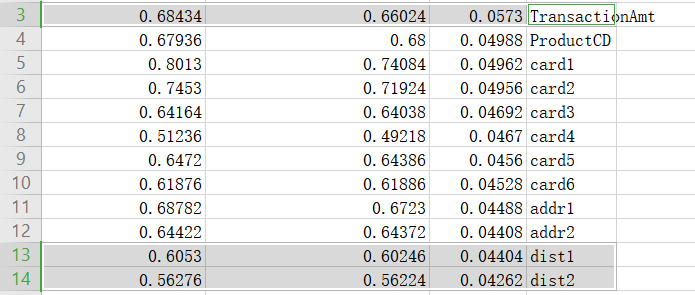
三个特征的泛化误差 auc_delta都下降了

In [96]:
cols=list(X.columns)
cols.remove('TransactionDT')#
for col in ['TransactionAmt','dist1','dist2']:
    cols.remove(col)
clfs=lgb_model(params=params,cv=KFold(5),X=X,y=y,early_stopping_rounds=200,cols=cols,categorical_feature=None,group_feature=None)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.945306	valid_1's auc: 0.881084
[200]	training's auc: 0.961174	valid_1's auc: 0.890757
[300]	training's auc: 0.975811	valid_1's auc: 0.899005
[400]	training's auc: 0.984928	valid_1's auc: 0.90552
[500]	training's auc: 0.990102	valid_1's auc: 0.909826
[600]	training's auc: 0.993302	valid_1's auc: 0.912227
[700]	training's auc: 0.995324	valid_1's auc: 0.913705
[800]	training's auc: 0.996582	valid_1's auc: 0.91441
[900]	training's auc: 0.997479	valid_1's auc: 0.915046
[1000]	training's auc: 0.998109	valid_1's auc: 0.915373
[1100]	training's auc: 0.998564	valid_1's auc: 0.915389
[1200]	training's auc: 0.9989	valid_1's auc: 0.915245
Early stopping, best iteration is:
[1007]	training's auc: 0.998144	valid_1's auc: 0.915439
Fold 1 | AUC: 0.9154391772841276
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.944764	valid_1's auc: 0.903156
[200]	training's auc: 0.961122	valid_1

In [104]:
cols=list(X.columns)
cols.remove('TransactionDT')#
for col in ['TransactionAmt','dist1','dist2','log_dist1','log_dist2']:
    cols.remove(col)
clfs=lgb_model(params=params,cv=KFold(5),X=X,y=y,early_stopping_rounds=200,cols=cols,categorical_feature=None,group_feature=None)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.945022	valid_1's auc: 0.881824
[200]	training's auc: 0.960933	valid_1's auc: 0.89191
[300]	training's auc: 0.975251	valid_1's auc: 0.899249
[400]	training's auc: 0.984451	valid_1's auc: 0.905784
[500]	training's auc: 0.989591	valid_1's auc: 0.909925
[600]	training's auc: 0.99293	valid_1's auc: 0.912501
[700]	training's auc: 0.994981	valid_1's auc: 0.914331
[800]	training's auc: 0.996279	valid_1's auc: 0.915152
[900]	training's auc: 0.997192	valid_1's auc: 0.915509
[1000]	training's auc: 0.997819	valid_1's auc: 0.915592
[1100]	training's auc: 0.99829	valid_1's auc: 0.915497
Early stopping, best iteration is:
[948]	training's auc: 0.997519	valid_1's auc: 0.915625
Fold 1 | AUC: 0.9156246742886543
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.943755	valid_1's auc: 0.90131
[200]	training's auc: 0.960639	valid_1's auc: 0.911356
[300]	training's auc: 0.975315	valid_1's

In [105]:
#X_test[cat]=X_test[cat].astype(np.int64)
y_pred=np.zeros(X_test.shape[0])
for clf in clfs:
    y_pred+=clf.predict_proba(X_test[cols])[:,1]/5
sub=pd.read_csv('sample_submission.csv')
sub['isFraud']=y_pred
sub.to_csv('.\submit\cat2int_transactionamt2log.csv',index=False)

## 整体的特征的偏移程度已经得到了较好的缓解，下面就准备进行一些特征衍生了

In [ ]:
X.to_csv('F:\kaggle_ieee\data\X.csv',index-False)
X_test.to_csv('F:\kaggle_ieee\data\X.csv',index-False)